# Generation of *q2q* transforms

This notebook is to implement different versions of *q2q* transformations to be exported and employed in pypsa-es.

In [1]:
######################################## Import packages and local code


########## Packages
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import sys
import yaml
import numpy as np

# To fit CDF
from scipy.stats import ecdf
from scipy.interpolate import interp1d

# For creating the transform object
import pickle



########## Local code
local_folder = '/home/aerolinux3/clouds_and_repos/ownCloud/08_python/200_Aarhus/pypsa-eur_analysis_funs/local_funs/'
sys.path.append(local_folder)

from fun_aggregate_network_time_series import fun_aggregate_network_time_series



In [2]:
######################################## Parameters

########## network_file (check info in 'q2q_dic.yaml')
version = 'v001'

########## Carrier considered
carrier = 'onwind'


########## Folder to store the q2q transform
q2q_folder = 'collection/'

########## Plot parameters
nbins = 70
fontsize = 15
labelsize = 13



In [3]:
######################################## Derived parameters
q2q_file = f'q2q_{carrier}_{version}'


######################################## Additional info

########## read yaml dic
with open('q2q_dic.yaml', 'r') as archivo:    
    q2q_dic = yaml.safe_load(archivo)



In [4]:
######################################## Retrieve q2q transform input (pypsa dispatch)

########## Load network with renewable generation profiles
n_file = q2q_dic[version]['network_file_q2q_generation']
n = pypsa.Network(n_file)

########## Several operations
# - obtain a dic with aggregated info accross nodes
# - obtain the dataframe with generation time series ('df')
# - keep the carrier of interest, in the form of a df
df_input = fun_aggregate_network_time_series(n)['df'][carrier].to_frame()


INFO:pypsa.io:Imported network elec_s_25_lv1.0__1H_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
######################################## Retrieve q2q transform target (ESIOS)

########## Several operations
# - load ESIOS file with generation time series
# - keep the carrier of interest, in the form of a df
esios_file = q2q_dic[version]['ESIOS_file']
df_target = pd.read_csv(esios_file)[q2q_dic['ESIOS_carriers'][carrier]].to_frame()


########## Replace the carrier name
### Invert keys and values of the dic ESIOS_carriers
ESIOS_carriers_inverted = {v: k for k, v in q2q_dic['ESIOS_carriers'].items()}
### Replace column name
df_target.rename(columns=ESIOS_carriers_inverted, inplace=True)


########## Replace negative values by 0
df_target[df_target<0]=0

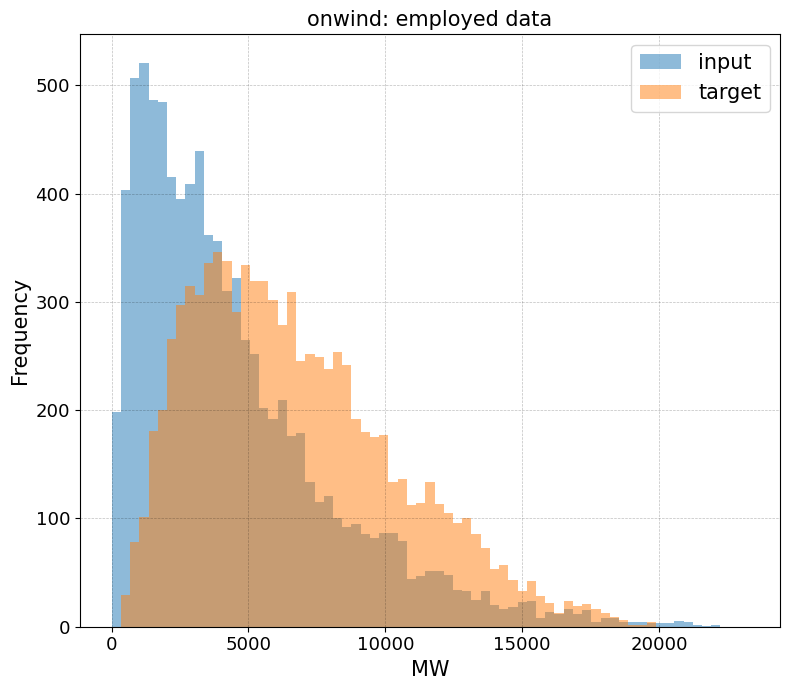

In [6]:
######################################## Have a look at the PDFs
fig, ax1 = plt.subplots(1,1,figsize=(8,7))

### Imponer rango donde distribuir los bins, para que bin width no de dependa de la variable
x_min = 0
x_max = 1.05*max([df_input.max().max(),df_target.max().max()])
bins=np.linspace(x_min, x_max, nbins)

### Asses target variables to avoid printing the outputs of hist function
vv, hh, nn = ax1.hist(df_input[carrier], bins=bins, alpha=0.5, label='input')
vv, hh, nn = ax1.hist(df_target[carrier], bins=bins, alpha=0.5, label='target')

# Agregar etiquetas y leyenda
ax1.set_xlabel('MW', fontsize=fontsize)
ax1.set_ylabel('Frequency', fontsize=fontsize)
ax1.set_title(f'{carrier}: employed data', fontsize=fontsize)
ax1.legend(fontsize=fontsize)

ax1.tick_params(axis='both', which='major', labelsize=labelsize)

# Add grid lines
ax1.yaxis.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)
ax1.xaxis.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)


# If solar, set a maximum on y-axis
if carrier == 'solar':
    ax1.set_ylim(0 , 1.2*8760/nbins)



##### Export figure
fig_name = f'figs/{q2q_file}_fig01_data_histo.jpg'
fig.tight_layout()

plt.savefig(fig_name)


/tmp/ipykernel_127326/1015571729.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


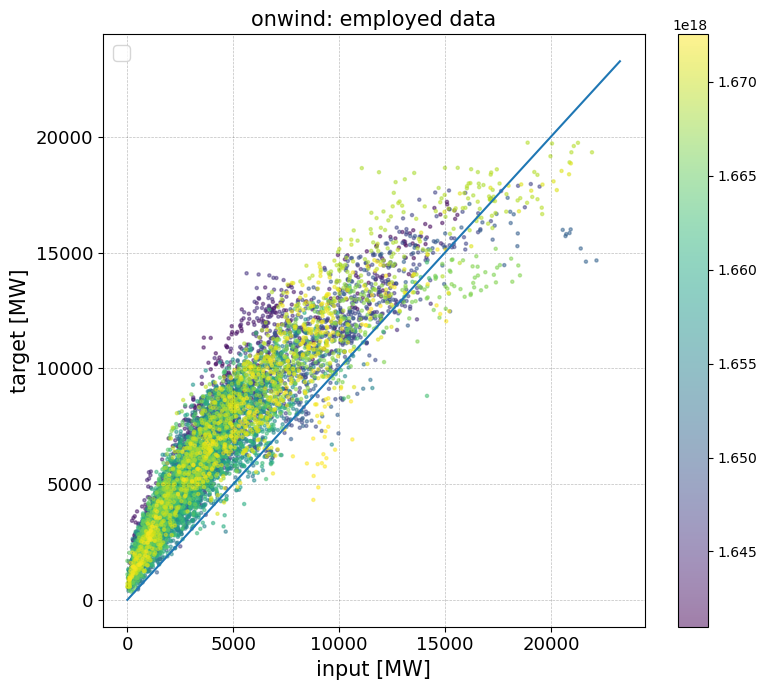

In [7]:
######################################## Have a look at the linear relationship

fig, ax = plt.subplots(1,1,figsize=(8,7))

plt.scatter(df_input[carrier], df_target[carrier], 
            c=pd.to_numeric(df_input.index), ### to explore season dependency
            s = 5,
            alpha=0.5)

### to explore season dependency
cbar = plt.colorbar()

plt.xlabel('input [MW]', fontsize=fontsize)
plt.ylabel('target [MW]', fontsize=fontsize)
ax.legend(fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=labelsize)

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

ax.set_title(f'{carrier}: employed data', fontsize=fontsize)

x_max = 1.05*max([df_input.max().max(),df_target.max().max()])
plt.plot([0, x_max],[0, x_max])


##### Export figure
fig_name = f'figs/{q2q_file}_fig02_data_scatter.jpg'
fig.tight_layout()

plt.savefig(fig_name)

In [8]:
######################################## Normalise input and target
#
# Here there are several criteria
#
# (1): norm_v1
#      normalise both with the installed capacity. The problem is that, 
#      since input/target is aggregated generation, maximum generation 
#      is never reached. Thus, the transform needs to be artificially 
#      extended (linearly) up to 1. In addition, the installed capacity
#      is required.
#
# (2): norm_v2
#      normalised both input and target with the maximum value attained by both 
#      of them.
#
# (3): norm_v3
#      normalise input with its maximum and target with its maximum. The problem
#      is that conversion bias at high generation level is ignored. 
#      However, since input/target is at national level, and the transform
#      is to be applied at Voronoi cell level, this could be beneficial.
#
#


if q2q_dic[version]['norm_rule'] == 'norm_v1':
    
    installed_capacity = n.generators[n.generators.index.str.contains(carrier)]['p_nom'].sum()

    df_input = df_input.div(installed_capacity)
    df_target = df_target.div(installed_capacity)



if q2q_dic[version]['norm_rule'] == 'norm_v2':
    
    x_max = max([df_input.max().max(),df_target.max().max()])

    df_input = df_input.div(x_max)
    df_target = df_target.div(x_max)



if q2q_dic[version]['norm_rule'] == 'norm_v3':
    
    input_max = df_input.max().max()
    target_max = df_target.max().max()

    df_input = df_input.div(input_max)
    df_target = df_target.div(target_max)    




/tmp/ipykernel_127326/4141479894.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=fontsize)


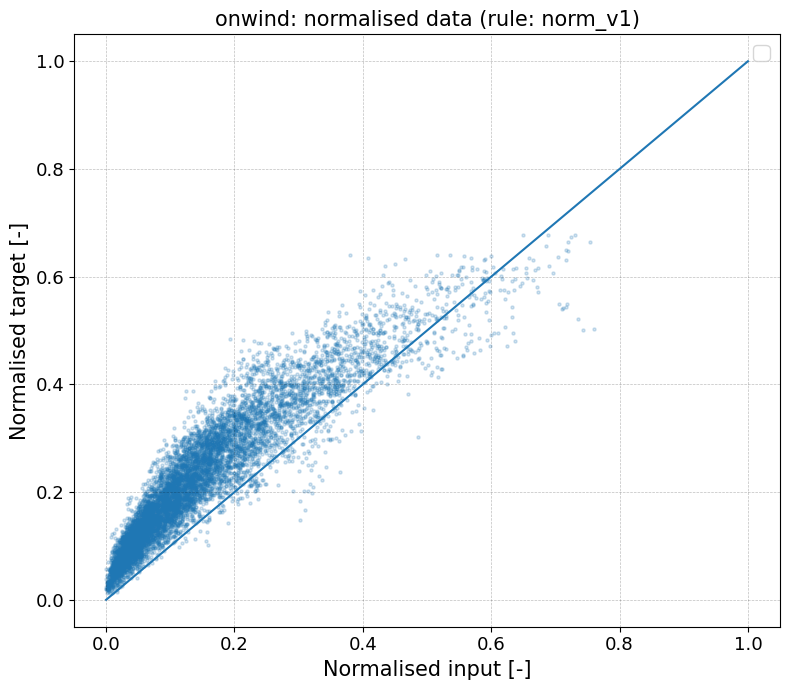

In [9]:
######################################## Have a look at the linear relationship

fig, ax = plt.subplots(1,1,figsize=(8,7))

plt.scatter(df_input[carrier], df_target[carrier], 
            # c=pd.to_numeric(df_input.index), ### to explore season dependency
            s = 5,
            alpha=0.2)

### to explore season dependency
#cbar = plt.colorbar()

plt.xlabel('Normalised input [-]', fontsize=fontsize)
plt.ylabel('Normalised target [-]', fontsize=fontsize)
ax.legend(fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=labelsize)


# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

ax.set_title(f'{carrier}: normalised data (rule: {q2q_dic[version]["norm_rule"]})', fontsize=fontsize)


x_max = 1
plt.plot([0, x_max],[0, x_max])


##### Export figure
fig_name = f'figs/{q2q_file}_fig03_normalised_data_scatter.jpg'
fig.tight_layout()

plt.savefig(fig_name)



In [10]:
######################################## Get q2q transform

def transformation(ts_input,ts_target):

    ecdf_input = ecdf(ts_input)
    ecdf_target = ecdf(ts_target)


    y0 = ecdf_input.cdf.evaluate(ts_input)
    y1 = y0

    x_values = ecdf_target.cdf.quantiles
    y_values = ecdf_target.cdf.probabilities


    interp_func = interp1d(y_values, x_values, kind='zero')

    ts_output = interp_func(y1)

    return ts_output


### Add a "0" and "1" at the end of input/target time series,
# so that minimum and maximum values are always attained
# (actually something below 0 and above 1 to avoid interpolation errors)
ts_input = np.append(df_input.values, -0.001)
ts_target = np.append(df_target.values, -0.001)

ts_input = np.append(ts_input, 1.001)
ts_target = np.append(ts_target, 1.001)


### Get the output time series that has same CDF as target
ts_output = transformation(ts_input,ts_target)


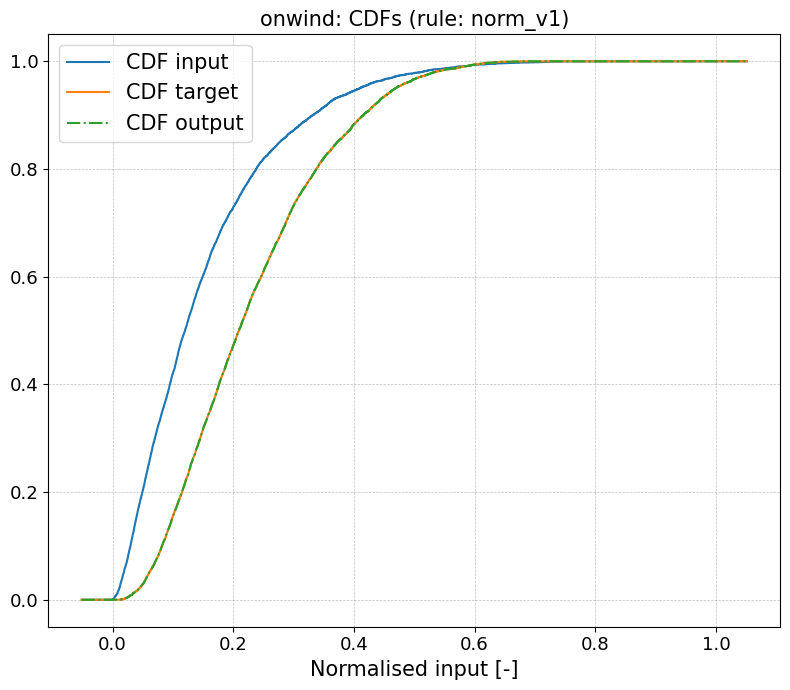

In [11]:
######################################## Have a look at the CDFs


ecdf_input = ecdf(ts_input)
ecdf_target = ecdf(ts_target)
ecdf_output = ecdf(ts_output)


fig, ax = plt.subplots(1,1,figsize=(8,7))

ecdf_input.cdf.plot(ax=ax, label='CDF input')
ecdf_target.cdf.plot(ax=ax, label='CDF target')
ecdf_output.cdf.plot(ax=ax, label='CDF output',linestyle='-.')

# Add grid lines
plt.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

ax.legend(fontsize=fontsize)

ax.set_title(f'{carrier}: CDFs (rule: {q2q_dic[version]["norm_rule"]})', fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=labelsize)

plt.xlabel('Normalised input [-]', fontsize=fontsize)


##### Export figure
fig_name = f'figs/{q2q_file}_fig04_CDFs.jpg'
fig.tight_layout()

plt.savefig(fig_name)

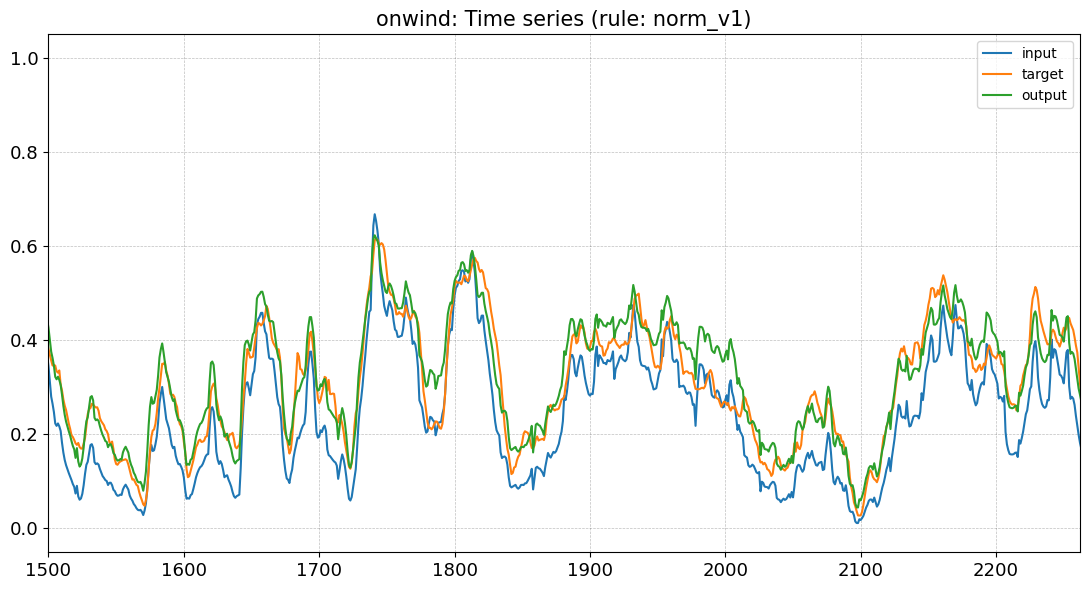

In [12]:
######################################## Have a look at the time series

fig, ax = plt.subplots(1,1,figsize=(11,6))

ax.plot(ts_input, label='input')
ax.plot(ts_target, label='target')
ax.plot(ts_output, label='output')


ax.tick_params(axis='both', which='major', labelsize=labelsize)

ax.set_title(f'{carrier}: Time series (rule: {q2q_dic[version]["norm_rule"]})', fontsize=fontsize)


t0 = 1500
w = 762
ax.set_xlim(t0, t0+w)

plt.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)
ax.legend()


##### Export figure
fig_name = f'figs/{q2q_file}_fig05_time_series.jpg'
fig.tight_layout()

plt.savefig(fig_name)

In [13]:
######################################## Compute and save q2q transform

##### First, compute a transform with all the data
q2q_transform_whole = interp1d(ts_input,ts_output, kind='linear')

##### Use it to generate a reduced input/output dataset (with 5000 elements) 
x_values = np.linspace(-0.001, 1.001, 1000)
y_values = q2q_transform_whole(x_values)

##### Use the 1000 sample input/output to compute the final transform
q2q_transform = interp1d(x_values,y_values, kind='linear')


##### Save transform
with open(f'{q2q_folder}{q2q_file}.pkl', 'wb') as f:
    pickle.dump(q2q_transform, f)


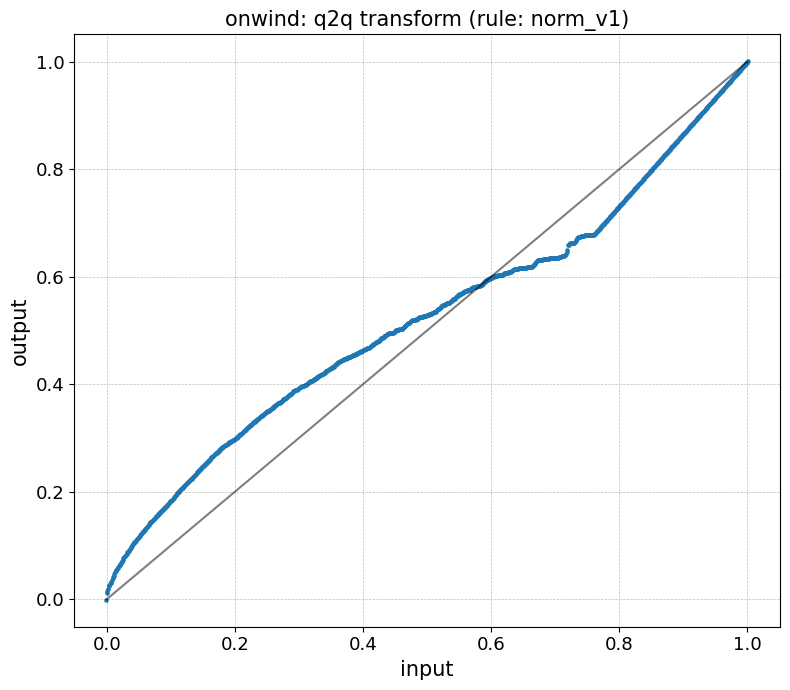

In [14]:
######################################## Have a look at the obtained transform

fig, ax = plt.subplots(1,1,figsize=(8,7))


ax.scatter(x_values,y_values,s=5)
ax.plot([0, 1],[0, 1],color='black',alpha=0.5)

ax.set_xlabel('input', fontsize=fontsize)
ax.set_ylabel('output', fontsize=fontsize)
ax.grid(True, linestyle='--', linewidth=0.5, color='black', alpha=0.25)

ax.tick_params(axis='both', which='major', labelsize=labelsize)

ax.set_title(f'{carrier}: q2q transform (rule: {q2q_dic[version]["norm_rule"]})', fontsize=fontsize)

##### Export figure
fig_name = f'figs/{q2q_file}_fig06_q2q_transform.jpg'
fig.tight_layout()

plt.savefig(fig_name)

